In [1]:
%matplotlib inline
import os
import pandas as pd

# Dataset

Source: [Heterogeneity Activity Recognition Data Set](https://archive.ics.uci.edu/ml/datasets/Heterogeneity+Activity+Recognition)

The dataset and accompanying research can befound at UCIs dataset repository. The dataset is provided as a single archive. For my convenience I separated the included datasets into their own archives.

In [2]:
data_directory = os.environ["DATASET"] + "/heterogeneity_activity_recognition"
phone_accelerometer_path = f"{data_directory}/phones_accelerometer.zip"
phone_gyroscope_path = f"{data_directory}/phones_gyroscope.zip"
output_path = f"{data_directory}/processed/phones.zip"

# Preprocessing

**`read`** opens a device dataset, and performs some basic processing. Columns are pruned and column names are normalized, categorial data is converted to categorical respresentations, and the dataset is indexed on time. The arrival time is used for the time index to provide a standard across all devices.

In [3]:
def read(path):
    return (
        pd.read_csv(path)
        .rename(columns=str.lower)
        .rename(columns={"gt": "target"})
        .set_index("arrival_time")
        .drop(columns=["creation_time", "device", "index", "model"])
        .assign(
            target=lambda df: pd.Categorical(df["target"]),
            user=lambda df: pd.Categorical(df["user"])
        )
    )

# Merge

**`df`** is the accelerometer and gyroscope datasets merged on their time axis. This produces rows with incomplete data where one dataset had a timestamp that the other did not. In those cases the data is dropped.

In [4]:
%time df = (read(phone_accelerometer_path).join(read(phone_gyroscope_path), lsuffix="_accel", rsuffix="_gyro").dropna()); df.head(1)

CPU times: user 46.8 s, sys: 5.29 s, total: 52.1 s
Wall time: 52.2 s


,x_accel,y_accel,z_accel,user_accel,target_accel,x_gyro,y_gyro,z_gyro,user_gyro,target_gyro
arrival_time,,,,,,,,,,
1424686733391,-2.779668,1.908179,8.927979,g,stand,0.015577,-0.043371,-0.014661,g,stand


## Merge Conflicts

Each dataset has a target and a user column that gets a unique suffix for each dataset. To make things easier to work with one of those columns is dropped, and the column names are returned to `target` and `user`.

In [5]:
def normalize_target(df):
    return (
        df.rename(columns={"target_accel": "target"})
        .drop(columns=["target_gyro"])
    )

In [6]:
def normalize_user(df):
    return (
        df.rename(columns={"user_accel": "user"})
        .drop(columns=["user_gyro"])
    )

The dataframe is overwritten with the changes made by the normalization functions. The columns are sorted at this step as well.

In [7]:
%time df = df.pipe(normalize_target).pipe(normalize_user).sort_index(axis="columns")

CPU times: user 373 ms, sys: 157 ms, total: 529 ms
Wall time: 530 ms


# Visualize

In [8]:
df.head()

,target,user,x_accel,x_gyro,y_accel,y_gyro,z_accel,z_gyro
arrival_time,,,,,,,,
1424686733391,stand,g,-2.779668,0.015577,1.908179,-0.043371,8.927979,-0.014661
1424686733401,stand,g,-2.779668,0.014355,1.908179,-0.035430,8.927979,-0.018021
1424686733411,stand,g,-2.789245,0.011301,1.916559,-0.026878,8.916007,-0.019548
1424686733421,stand,g,-2.774880,0.014050,1.878251,-0.008247,8.895657,-0.025045
1424686733431,stand,g,-2.766500,0.005498,1.856703,0.009468,8.883685,-0.016799


Sensor readings per user

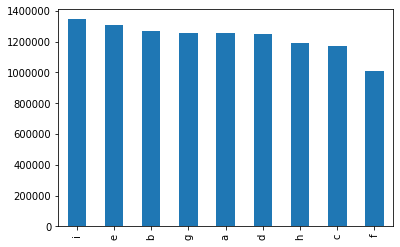

In [9]:
df.user.value_counts().plot(kind="bar");

Breakdown of the actions taken

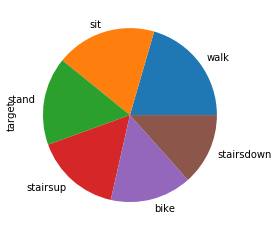

In [10]:
df.target.value_counts().plot(kind="pie");

# Export Dataset

In [11]:
%time df.to_csv(output_path)

CPU times: user 1min 49s, sys: 1.52 s, total: 1min 50s
Wall time: 1min 51s
